유사하다고 뽑힌 예시들이 결국 inference 시에 도움이 안될 수 있음.

1. 유사한 대화가 selection pool에 없어서 sub-optimal한 예시가 뽑힐 수 있기 때문.
2. 유사한 대화가 뽑혔지만 충분치 않을 수 있음.
3. 유사한 대화에 포함된 다른 정보들이 inference에 방해를 할 수 있음.

유사함만으로는 해결할 수 없으면 어떻게 할 수 있을까?

complexity 적용
* user dialogue 길이 (O)
* 전체 dialogue 길이 (O)
* context 개수 (O)
* 이전 turn과 비교해서 값이 변하거나 추가된 slot의 개수 (O)
* NER task를 이용해 entity로 잡힌 정보의 양 계산
* LLM에게 물어본 complexity 값

In [1]:
import json
import re

with open('data/mw21_100p_train.json','r') as f:
    train_dataset = json.load(f)

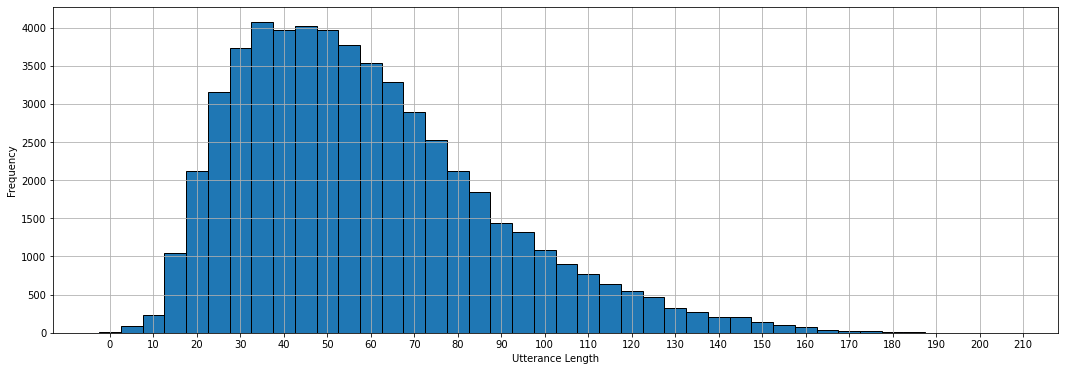

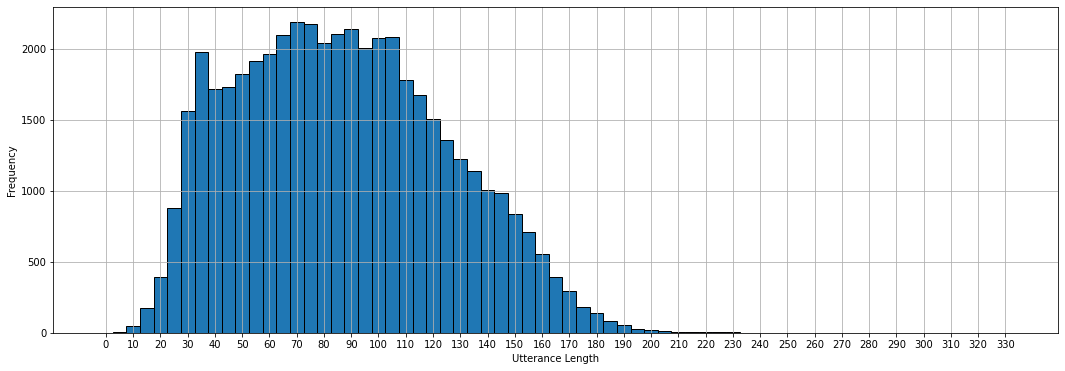

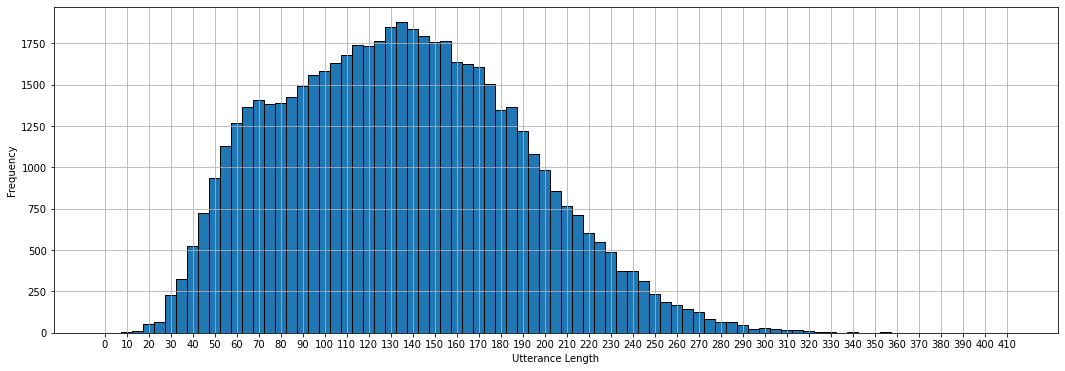

In [2]:
import matplotlib.pyplot as plt
import numpy as np

usr_len = []
sys_len = []
all_len = []

for data_idx, data_item in enumerate(train_dataset):
    usr_utt = data_item['dialog']['usr'][-1]
    sys_utt = data_item['dialog']['sys'][-1]
    
    usr_len.append(len(usr_utt))
    if not len(sys_utt) == 0: # 0일때는 지움
        sys_len.append(len(sys_utt))
        
    all_len.append(len(usr_utt) + len(sys_utt))
    
def plot_dist(input_list, n_width=10):
    hist, bins = np.histogram(input_list, bins=range(0, max(input_list) + 5, 5))
    plt.figure(figsize=(18, 6))
    plt.bar(bins[:-1], hist, width=5, edgecolor='black')
    plt.xlabel('Utterance Length')
    plt.ylabel('Frequency')
    plt.xticks(range(0, max(input_list) + 5, 10))
    plt.grid(True)

    plt.show()
    
plot_dist(usr_len)
plot_dist(sys_len)
plot_dist(all_len)

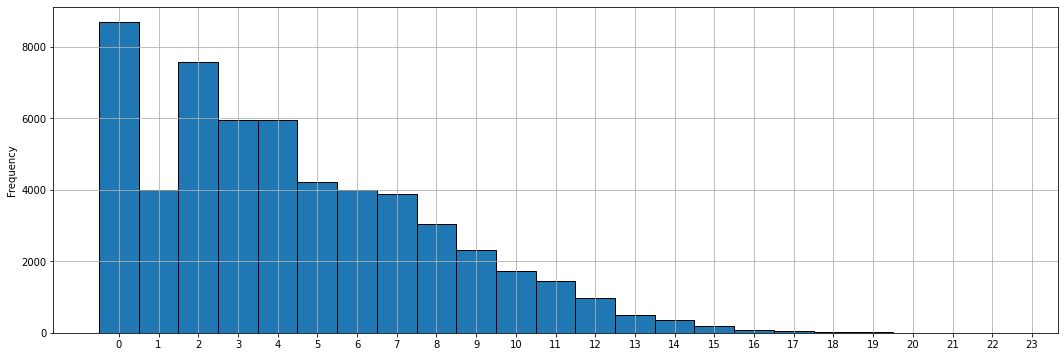

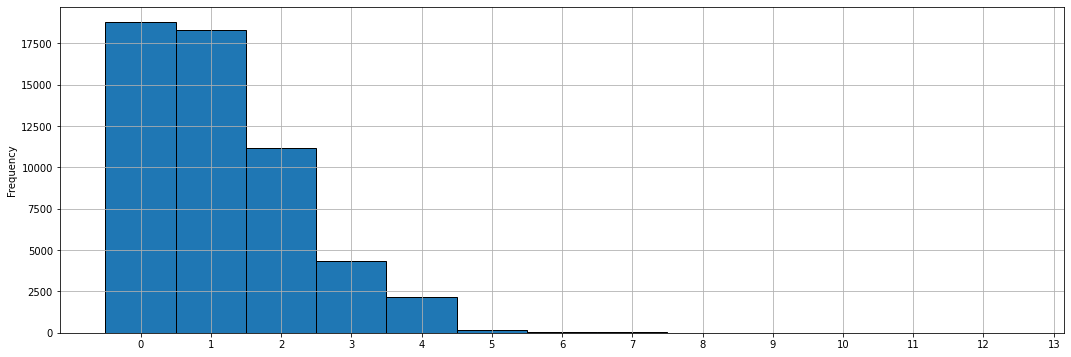

In [3]:
context_count = []
updated_count = []

for data_idx, data_item in enumerate(train_dataset):
    context_count.append(len(data_item['last_slot_values']))
    
    last_slot_values = data_item['last_slot_values']
    slot_values = data_item["slot_values"]
    
    n_update = 0
    for s,v in slot_values.items():
        if s in last_slot_values.keys():
            if v != last_slot_values[s]:
                n_update += 1
        else:
            n_update += 1
    
    updated_count.append(n_update)
    
def plot_dist(input_list):
    hist, bins = np.histogram(input_list, bins=range(0, max(input_list) + 5, 1))
    plt.figure(figsize=(18, 6))
    plt.bar(bins[:-1], hist, width=1, edgecolor='black')
    plt.ylabel('Frequency')
    plt.xticks(range(0, max(input_list) + 5, 1))
    plt.grid(True)

    plt.show()
    
plot_dist(context_count)
plot_dist(updated_count)

# retrieved example과 test instance 간의 complexity 비교

In [8]:
ontology = """Your task is to find the changed domain-slots based on the context and the dialogue between user and system, and find the corresponding value.
The following lists are domain-slots and their possible values.
you don't have to find other changed domain-slots if they are not in the list.

hotel-name: a and b guest house, ashley hotel, el shaddia guest house, etc.
hotel-pricerange: dontcare, cheap, moderate, expensive
hotel-type: hotel, guest house
hotel-parking: dontcare, yes, no
hotel-book stay: 1, 2, 3, etc.
hotel-book day: monday, tuesday, etc.
hotel-book people: 1, 2, 3, etc.
hotel-area: dontcare, centre, east, north, south, west
hotel-stars: dontcare, 0, 1, 2, 3, 4, 5
hotel-internet: dontcare, yes, no

train-destination: london kings cross, cambridge, peterborough, etc.
train-departure: cambridge, stansted airport, etc.
train-day: monday, saturday, etc.
train-book people: 1, 2, 3, etc.
train-depart_time: 20:24, 12:06, etc.
train-arrive_by_time: 05:51, 20:52, etc.

attraction-name: abbey pool and astroturf pitch, adc theatre, all saints church, castle galleries, etc.
attraction-area: dontcare, centre, east, north, south, west
attraction-type: architecture, boat, church, cinema, college, concert hall, entertainment, hotspot, multiple sports, museum, nightclub, park, special, swimming pool, theatre

restaurant-name: pizza hut city centre, the missing sock, golden wok, cambridge chop house, darrys cookhouse and wine shop, etc.
restaurant-food_type: italian, international, chinese, dontcare, modern european, etc.
restaurant-pricerange: dontcare, cheap, moderate, expensive
restaurant-area: centre, east, north, south, west
restaurant-book time: 13:30, 17:11, etc.
restaurant-book day: wednesday, friday, etc.
restaurant-book people: 1, 2, 3, etc.

taxi-destination: copper kettle, magdalene college, lovell lodge
taxi-departure: royal spice, university arms hotel, da vinci pizzeria
taxi-depart_time: 14:45, 11:15, etc.
taxi-arrive_by_time: 15:30, 12:45, etc.
"""

running_log_path = "expts/230517_0100-gpt35_turbo_5p_v2_baseline_save_examples_0to200/running_log.json"
with open(running_log_path,'r') as f:
    content = json.load(f)
    
from complexity.evaluate_complexity import ComplexityEvaluator
complex_evaluator = ComplexityEvaluator(train_data_path="data/mw21_5p_train_v2.json")
    
for idx, i in enumerate(content[:200]):
#     if i["pred_status"] == "wrong" and i["predicted_slot_values"] != i["turn_slot_values"]:
#         last_slot_values = {s: v.split('|')[0] for s, v in i['last_slot_values'].items()}
#         if not all(item in last_slot_values.items() for item in i["predicted_slot_values"].items()):

    print("********** " + str(idx) + " **********\n")
    print(i["prompt"].replace(ontology,""))
    print("\n")
    print("prediction ==== " + str(i["predicted_slot_values"]))
    print("labeling.. ==== " + str(i["turn_slot_values"]))
    
    print(f"target length complexity: {complex_evaluator.length_complexity_score(i)}")
    print(f"target context complexity: {complex_evaluator.context_complexity_score(i)}")
    
    examples_length_complexity = []
    examples_context_complexity = []
    
    for example in i["examples"]:
#         print(f"example length complexity: {complex_evaluator.length_complexity_score(example)}")
#         print(f"example context complexity: {complex_evaluator.context_complexity_score(example)}")
        examples_length_complexity.append(complex_evaluator.length_complexity_score(example))
        examples_context_complexity.append(complex_evaluator.context_complexity_score(example))
        
    print(f"examples'mean of length complexity: {sum(examples_length_complexity)/len(examples_length_complexity)}")
    print(f"examples'mean of context complexity: {sum(examples_context_complexity)/len(examples_context_complexity)}")
    
    print("\n\n\n\n\n\n\n\n\n")

********** 0 **********


Example #1
[context] (hotel-type = guest house), (hotel-parking = yes), (hotel-internet = yes), (attraction-type = park)
[system] sure ! milton country park is at cb46az . it s free admission .
[user] free is perfect . that will leave me extra to book a taxi from my hotel .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (taxi-departure = acorn guest house)


Example #2
[context] (taxi-destination = pembroke college)
[system] where will you be departing from ?
[user] i need to leave from primavera
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (taxi-departure = primavera)


Example #3
[context] 
[system] 
[user] i want to get a taxi to pick me up from the cambridge train station please .
Q: Based on current dialog

target context complexity: 0.6027051561365286
examples'mean of length complexity: 0.6285039941902687
examples'mean of context complexity: 0.32295388525780694










********** 120 **********


Example #1
[context] (restaurant-book people = 7), (restaurant-name = charlie chan), (restaurant-book time = 11:00), (attraction-type = museum), (restaurant-book day = tuesday), (attraction-area = west)
[system] the phone number is 01223335153 . may i assist with something else ?
[user] that s all for now . thank you for everything .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: 


Example #2
[context] (hotel-type = hotel), (hotel-parking = yes), (train-day = monday), (train-departure = cambridge), (train-destination = kings lynn), (train-arrive_by_time = 14:45), (hotel-area = centre), (hotel-pricerange = expensive), (hotel-stars = 4)
[system] of course ! the phone num

In [95]:
text = """Example #1
[context] (attraction-area = centre)
[system] there are 44 possible options . what type of attraction are you interested in ?
[user] i do not mind what kind .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (attraction-type = dontcare)


Example #2
[context] (attraction-area = south)
[system] would you be interested in a museum ? the byard art museum is located at 14 king s way in the south .
[user] that sounds good . can you tell me the entrance fee and phone number ?
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (attraction-name = byard art), (attraction-type = museum)


Example #3
[context] (restaurant-food_type = dontcare), (restaurant-pricerange = cheap), (restaurant-area = south)
[system] nandos is a cheap restaurant in the south part of town , serving portuguese food .
[user] is there anything else ?
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: 


Example #4
[context] (attraction-type = boat), (restaurant-food_type = french), (restaurant-book day = wednesday), (attraction-area = north), (restaurant-name = 2 two), (restaurant-book time = 13:45), (restaurant-book people = 8)
[system] riverboat georgina meets your criteria . would you like more information ?
[user] can you give me the address and entrance fee to this attraction ? thank you for your help !
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (restaurant-name = [DELETE])


Example #5
[context] (attraction-area = west)
[system] sorry , i do not have that information . you can call them to find out . 01223332138 and 01223312112 are the phone numbers .
[user] can you tell me what type of attraction cafe jello gallery is please ? i also want to find an indian restaurant .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (attraction-name = cafe jello gallery), (restaurant-food_type = indian)


Example #6
[context] (attraction-type = entertainment), (restaurant-book people = 4), (restaurant-book time = 19:30), (attraction-area = south), (restaurant-pricerange = expensive), (restaurant-book day = monday), (restaurant-name = peking restaurant), (restaurant-area = south), (restaurant-food_type = chinese)
[system] i have 2 great options for entertainment venue -s in the south . 1 is nusha and the other is tenpin . but , if you do not mind a suggestion i would say nusha .
[user] sounds good . i need the address and phone number for them too .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: 


Example #7
[context] (train-depart_time = 15:45), (train-book people = 1), (train-destination = stansted airport), (train-day = sunday), (train-departure = cambridge)
[system] ok , you are booked on tr7062 , leaving at 16:40 and arriving by 17:08 , reference number 1msvtp4g . the price will be 10.10 at the station . can i help you with anything else ?
[user] yes , i was wondering if you could help me find ou abou an attraction called gonville and caius college .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (attraction-name = gonville and caius college)


Example #8
[context] (taxi-depart_time = 12:45), (train-depart_time = 12:45), (train-day = monday)
[system] tr6110 has a total travel time of 51 minutes . can i help you with anything else today ?
[user] yes , can you tell me about the hotpot restaurant ?
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (restaurant-name = the hotpot)


Example #9
[context] (hotel-book stay = 4), (hotel-book people = 6), (hotel-stars = 4), (hotel-type = guest house), (hotel-pricerange = cheap), (hotel-book day = tuesday), (hotel-name = alexander bed and breakfast)
[system] okay . your booking was successful and the reference number is 7sjqkm1t .
[user] thank you . while i have your attention , do you mind looking up a particular attraction for me ? i believe it was called hughes hall .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (attraction-name = hughes hall)


Example #10
[context] (restaurant-food_type = portugese), (restaurant-area = south)
[system] nandos is a portuguese restaurant in the south part of town . their address is cambridge leisure park clifton way and their phone number is 01223327908
[user] ok . thanks .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: 


Example #11
[context] restaurant-name = nusha
[system] could you double check that you've spelled the name correctly ? the closest i can find is nandos .
[user] it s not a restaurant , it s an attraction . nusha .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A:"""

# Define the regular expression patterns
pattern_context = r"\[context] (.+)"
pattern_system = r"\[system] (.+)"
pattern_user = r"\[user\] (.+)"
pattern_answer = r"A: (.+)"

# Split the text into individual examples
examples = re.split(r"\n\nExample #\d+\n", text)
examples = examples[1:]  # Skip the first empty item

# Iterate over the examples and extract the relevant lines
for i, example in enumerate(examples, start=1):
    context = re.search(pattern_context, example).group(1)
    system = re.search(pattern_system, example).group(1)
    user = re.search(pattern_user, example).group(1)
    answer = re.search(pattern_answer, example).group(1)

    print(f"Example #{i}")
    print("Context:", context)
    print("System:", system)
    print("User:", user)
    print("Answer:", answer)
    print()


Example #1
[context] (attraction-area = centre)
[system] there are 44 possible options . what type of attraction are you interested in ?
[user] i do not mind what kind .
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (attraction-type = dontcare)

[context] (attraction-area = south)
[system] would you be interested in a museum ? the byard art museum is located at 14 king s way in the south .
[user] that sounds good . can you tell me the entrance fee and phone number ?
Q: Based on current dialogue states ([context]), system utterance ([system]), and user utterance ([user]), what domain-slots have been changed and what are their values?
A: (attraction-name = byard art), (attraction-type = museum)

[context] (restaurant-food_type = dontcare), (restaurant-pricerange = cheap), (restaurant-area = south)
[system] nandos is a cheap restaurant in the south part of town , 